### This is a rough notebook which was used for the visualizations and results. Just attached for reference.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
import pickle

In [3]:
data = pd.read_csv("../Data/Data-LinksAdded.csv")

In [4]:
data.head()

,Unnamed: 0,type,posts
0,0,INFJ,enfp and intj moments sportscente...
1,1,ENTP,i m finding the lack of me in these posts ver...
2,2,INTP,good one of course to which i s...
3,3,INTJ,dear intp i enjoyed our conversation the o...
4,4,ENTJ,you re fired that s another silly misconce...


In [5]:
from nltk.stem import WordNetLemmatizer

class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]

In [6]:
with open('models/vectorizer.pk', 'rb') as f:
    vectorizer = pickle.load(f)

# with open('models/model_cat-Links+.pkl', 'rb') as f:
#     model = pickle.load(f)

with open('models/target-encoder.pk', 'rb') as f:
    labelEncoder = pickle.load(f)

In [7]:
# data.posts = vectorizer.transform([data.posts]).toarray()

In [8]:
# Stratify split to ensure equal distribution of data
from sklearn.model_selection import train_test_split

train_post,test_post, train_target, test_target = train_test_split(data['posts'], data['type'] ,test_size=0.20,random_state=42,stratify=data['type'])

In [9]:
from tqdm import tqdm
import re

In [10]:
def clear_text(data):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    cleaned_text=[]

    for sentence in tqdm(data):
        
#         print(sentence)

        sentence=sentence.lower()
        
        # tempLinks = [i[0] for i in re.findall('((http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-]))', sentence)]

        # tempLinks = [i for i in tempLinks if 'youtube' in i or 'youtu.be' in i or 'vimeo' in i or 'personalitycafe' in i]

        sentence=re.sub('((http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-]))', ' ' ,sentence)

        # sentence += replaceLinks(tempLinks)

        sentence=re.sub('[^0-9a-z]',' ',sentence)
    
        
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)

    return cleaned_text,data_length

In [11]:
test_post, test_length = clear_text(test_post)

100%|████████████████████████████████████████████████████████████████████████████| 1735/1735 [00:00<00:00, 2275.77it/s]


In [12]:
data_posts = vectorizer.transform(test_post).toarray()

C:\Users\Sashank Kakaraparty\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  % sorted(inconsistent)


In [38]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics

# modelAccuracy = {}
# modelF1 = {}
CATmodelAUC = {}

models = os.listdir('models/bestModels')

# with open('models/vectorizer.pk', 'rb') as f:
#     vectorizer = pickle.load(f)

# # with open('models/model_cat-Links+.pkl', 'rb') as f:
# #     model = pickle.load(f)

# with open('models/target-encoder.pk', 'rb') as f:
#     labelEncoder = pickle.load(f)


test_target_enc = labelEncoder.transform(test_target)
d = np.unique(test_target_enc)
class_name = list(d.flatten())

print(class_name)

for modelName in models[:1]:
    if '.pkl' in modelName and 'xgb' not in modelName:
        with open(f'models/{modelName}', 'rb') as f:
            model = pickle.load(f)
            
        print(modelName)
        for p in class_name:
            fpr, tpr, thresholds = metrics.roc_curve(test_target_enc,  
                model.predict_proba(data_posts)[:,1], pos_label = p) 

            auroc = round(metrics.auc(fpr, tpr),2)
            print(labelEncoder.inverse_transform([p]),'--AUC--->',auroc)
            CATmodelAUC[labelEncoder.inverse_transform([p])[0]] = auroc
#         pred_y = model.predict(data_posts)
#         modelAccuracy[modelName] = accuracy_score(test_target_enc, pred_y)
#         modelF1[modelName] = f1_score(test_target_enc, pred_y, average = 'weighted')
#         modelAUC[modelName] = roc_auc_score(test_target_enc, pred_y, multi_class="ovr")
#         print("Hola?")
''#         print(modelName,labelEncoder.inverse_transform(model.predict(target_text)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
model_cat-Links.pkl
['ENFJ'] --AUC---> 0.59
['ENFP'] --AUC---> 0.94
['ENTJ'] --AUC---> 0.5
['ENTP'] --AUC---> 0.5
['ESFJ'] --AUC---> 0.68
['ESFP'] --AUC---> 0.7
['ESTJ'] --AUC---> 0.73
['ESTP'] --AUC---> 0.5
['INFJ'] --AUC---> 0.45
['INFP'] --AUC---> 0.49
['INTJ'] --AUC---> 0.49
['INTP'] --AUC---> 0.3
['ISFJ'] --AUC---> 0.47
['ISFP'] --AUC---> 0.49
['ISTJ'] --AUC---> 0.6
['ISTP'] --AUC---> 0.42


In [39]:
CATmodelAUC

{'ENFJ': 0.59,
 'ENFP': 0.94,
 'ENTJ': 0.5,
 'ENTP': 0.5,
 'ESFJ': 0.68,
 'ESFP': 0.7,
 'ESTJ': 0.73,
 'ESTP': 0.5,
 'INFJ': 0.45,
 'INFP': 0.49,
 'INTJ': 0.49,
 'INTP': 0.3,
 'ISFJ': 0.47,
 'ISFP': 0.49,
 'ISTJ': 0.6,
 'ISTP': 0.42}

In [16]:
modelF1

{'Final-model_cat.pkl': 0.11702138806610543,
 'Final-model_LG-Reg.pkl': 0.09665483431120664,
 'Final-model_linear_svc.pkl': 0.11824317625042956,
 'model_cat-Links++.pkl': 0.11559457555709683,
 'model_cat-Links+.pkl': 0.09557963763864076,
 'model_cat-Links.pkl': 0.6622121579620625,
 'model_cat.pkl': 0.5647772366657065,
 'model_forest.pkl': 0.3607481000764678,
 'model_LG-Reg-Links++.pkl': 0.1005817614912371,
 'model_LG-Reg-Links.pkl': 0.5932833822254262,
 'model_LG-Reg.pkl': 0.48925574148444084,
 'model_linear_svc-Links+.pkl': 0.16287815364873937,
 'model_linear_svc-Links.pkl': 0.648381537449463,
 'model_linear_svc.pkl': 0.5501386897449357,
 'model_multinomial_nb.pkl': 0.3566652628584359,
 'model_svc-Links_ol.pkl': 0.6315499699166497,
 'model_svc.pkl': 0.49727813723252723,
 'model_tree.pkl': 0.44997060590231464}

In [20]:
modelAccuracy

{'Final-model_cat.pkl': 0.145821325648415,
 'Final-model_LG-Reg.pkl': 0.14755043227665707,
 'Final-model_linear_svc.pkl': 0.14236311239193083,
 'model_cat-Links++.pkl': 0.1435158501440922,
 'model_cat-Links+.pkl': 0.1377521613832853,
 'model_cat-Links.pkl': 0.6731988472622479,
 'model_cat.pkl': 0.5988472622478386,
 'model_forest.pkl': 0.4507204610951009,
 'model_LG-Reg-Links++.pkl': 0.15043227665706052,
 'model_LG-Reg-Links.pkl': 0.6293948126801153,
 'model_LG-Reg.pkl': 0.5515850144092219,
 'model_linear_svc-Links+.pkl': 0.20288184438040346,
 'model_linear_svc-Links.pkl': 0.6651296829971182,
 'model_linear_svc.pkl': 0.5919308357348703,
 'model_multinomial_nb.pkl': 0.4334293948126801,
 'model_svc-Links_ol.pkl': 0.6495677233429394,
 'model_svc.pkl': 0.5527377521613833,
 'model_tree.pkl': 0.4783861671469741}

In [22]:
pd.DataFrame(modelAccuracy.items(), columns=["Model", "Accuracy"]).to_csv("../../Report/ModelAcc.csv")

In [40]:
pd.DataFrame(CATmodelAUC.items(), columns=['Class', 'AUC']).to_csv("../../Report/AUCVals.csv")

In [94]:
data = pd.read_csv("../../Report/Tables/F1+Accuracy.csv")

In [95]:
data

,Model,F1,Accuracy
0,CAT Boost,0.662212,0.673199
1,Linear SVC,0.648382,0.665130
2,XGBoost,0.631550,0.649568
3,Neural Network,0.620000,0.640000
4,SVC,0.600000,0.610000
5,Logistic Regression,0.590000,0.620000
6,Random Forest,0.510000,0.490000


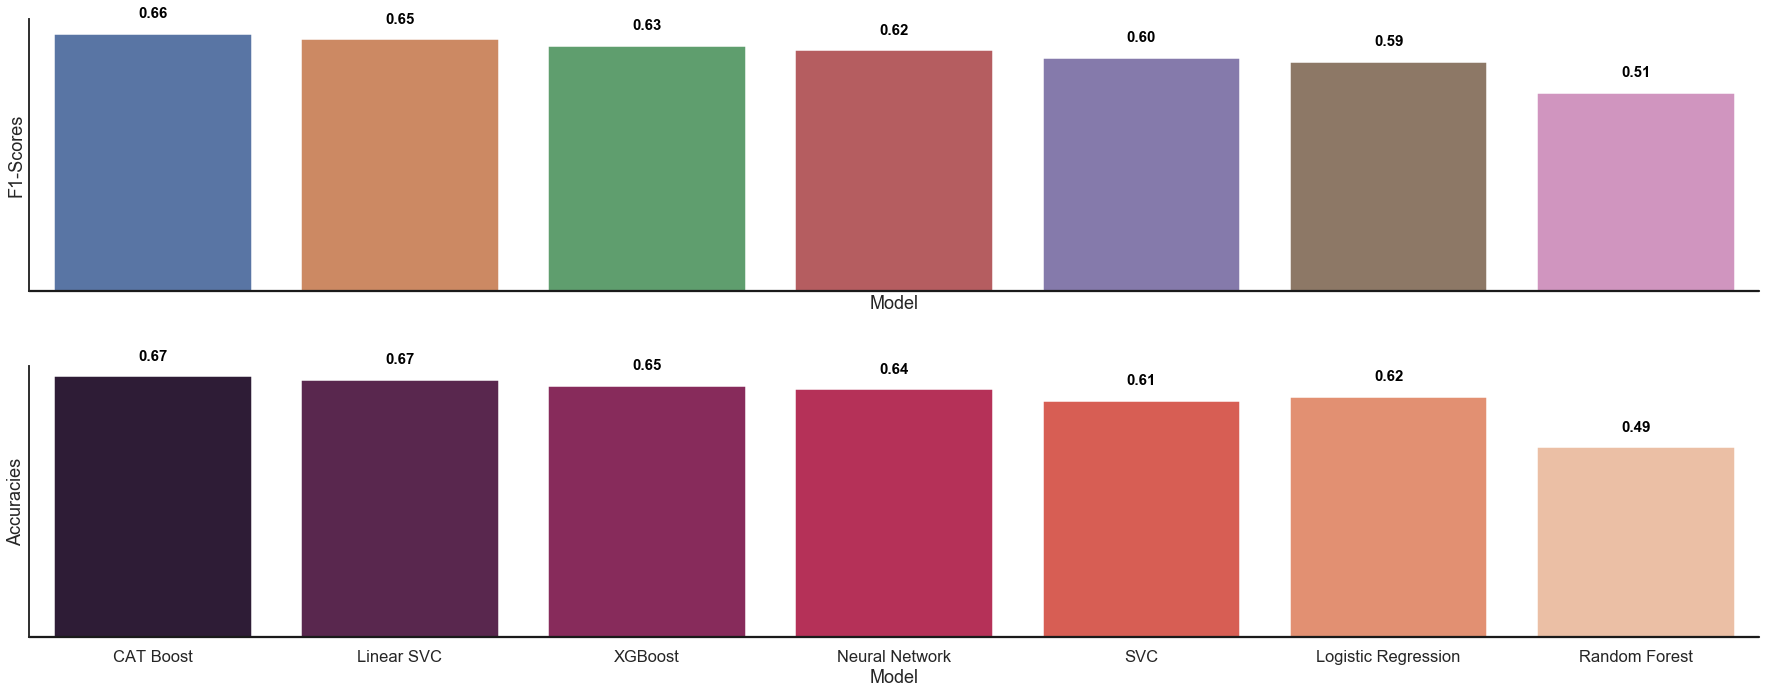

In [96]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", context="talk")
rs = np.random.RandomState(8)

# Set up the matplotlib figure
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 10), sharex=True)

# Generate some sequential data
x = data['Model'] 
y1 = data['F1']
sns.barplot(x=x, y=y1, palette="deep", ax=ax1).set_ylim(0,0.70)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("F1-Scores")

# Center the data to make it diverging
y2 = data['Accuracy']
sns.barplot(x=x, y=y2, palette="rocket", ax=ax2).set_ylim(0,0.70)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Accuracies")

for p in ax1.patches:
    ax1.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', weight='bold', fontsize=15, color='black', xytext=(0, 20),
                textcoords='offset points')
    
for p in ax2.patches:
    ax2.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', weight='bold', fontsize=15, color='black', xytext=(0, 20),
                textcoords='offset points')
# _ = g.set_ylim(0,120) #To make space for the annotations

sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)
plt.savefig('../../Report/Plots/ModelAccuracies+F1.png', dpi=64)

In [90]:
data = pd.read_csv("../../Report/Tables/AUCVals.csv")

In [91]:
data

,Unnamed: 0,Class,AUC
0,0,ENFJ,0.59
1,1,ENFP,0.94
2,2,ENTJ,0.50
3,3,ENTP,0.50
4,4,ESFJ,0.68
5,5,ESFP,0.70
6,6,ESTJ,0.73
7,7,ESTP,0.50
8,8,INFJ,0.45
9,9,INFP,0.49


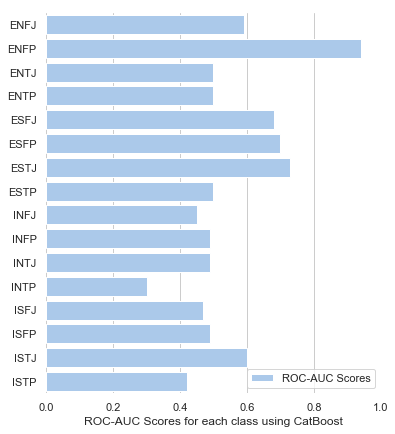

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 7))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="AUC", y="Class", data=data,
            label="ROC-AUC Scores", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 1), ylabel="",
       xlabel="ROC-AUC Scores for each class using CatBoost")
sns.despine(left=True, bottom=True)

plt.savefig('../../Report/Plots/ACUs.png', dpi=64)